In [8]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# Importing the dataset
from time import gmtime, strftime
import gc
from sklearn.model_selection import (train_test_split, GridSearchCV)
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from tqdm import tqdm
from sklearn.metrics import (roc_curve, auc, accuracy_score)
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler,MinMaxScaler




In [9]:
#new features are generated 

train_data = pd.read_csv('E:/ML_IP/ML_projects/datastorm/credit_card_default_train.csv')
predict_data = pd.read_csv('E:/ML_IP/ML_projects/datastorm/credit_card_default_test.csv')

#new engineered features
train_data['PAY_JULY_GREAT2']=train_data['PAY_JULY']>1.5 #APPLY ONE-HOT
train_data['PAY_AUG_GREAT1']=train_data['PAY_AUG']>1 #APPLY ONE-HOT
train_data['PAY_SEP_GREAT1']=train_data['PAY_SEP']>1 #APPLY ONE-HOT
train_data['PAY_OCT_GREAT1']=train_data['PAY_OCT']>1 #APPLY ONE-HOT
train_data['PAY_NOV_GREAT1']=train_data['PAY_NOV']>1 #APPLY ONE-HOT
train_data['PAY_DEC_GREAT1']=train_data['PAY_DEC']>1 #APPLY ONE-HOT
train_data['TOT']=train_data['PAY_JULY']+train_data['PAY_AUG']+train_data['PAY_SEP']+train_data['PAY_OCT']+train_data['PAY_NOV']+train_data['PAY_DEC']


predict_data['PAY_JULY_GREAT2']=predict_data['PAY_JULY']>1.5 #APPLY ONE-HOT
predict_data['PAY_AUG_GREAT1']=predict_data['PAY_AUG']>1 #APPLY ONE-HOT
predict_data['PAY_SEP_GREAT1']=predict_data['PAY_SEP']>1 #APPLY ONE-HOT
predict_data['PAY_OCT_GREAT1']=predict_data['PAY_OCT']>1 #APPLY ONE-HOT
predict_data['PAY_NOV_GREAT1']=predict_data['PAY_NOV']>1 #APPLY ONE-HOT
predict_data['PAY_DEC_GREAT1']=predict_data['PAY_DEC']>1 #APPLY ONE-HOT
predict_data['TOT']=predict_data['PAY_JULY']+predict_data['PAY_AUG']+predict_data['PAY_SEP']+predict_data['PAY_OCT']+predict_data['PAY_NOV']+predict_data['PAY_DEC']


cat_cols=['Gender', 'EDUCATION_STATUS',
       'MARITAL_STATUS', 'AGE', 'PAY_JULY_GREAT2',
       'PAY_AUG_GREAT1', 'PAY_SEP_GREAT1', 'PAY_OCT_GREAT1', 'PAY_NOV_GREAT1',
       'PAY_DEC_GREAT1']
train_data = pd.get_dummies( train_data,columns = cat_cols )
predict_data = pd.get_dummies( predict_data,columns = cat_cols )



In [15]:
t1=train_data.drop(['Client_ID', 'Balance_Limit_V1', 'PAY_AUG', 'PAY_SEP',
       'PAY_OCT', 'PAY_NOV', 'PAY_DEC', 
         'Gender_F',
       'Gender_M', 'EDUCATION_STATUS_Graduate', 'EDUCATION_STATUS_High School',
       'EDUCATION_STATUS_Other', 'MARITAL_STATUS_Other',
       'MARITAL_STATUS_Single', 'AGE_31-45', 'AGE_46-65', 'AGE_Less than 30',
       'AGE_More than 65', 'PAY_SEP_GREAT1_False',
       'PAY_SEP_GREAT1_True', 'PAY_OCT_GREAT1_False', 'PAY_OCT_GREAT1_True',
       'PAY_NOV_GREAT1_False', 'PAY_NOV_GREAT1_True', 'PAY_DEC_GREAT1_False',
       'PAY_DEC_GREAT1_True'],axis=1)


t2=predict_data.drop(['Client_ID', 'Balance_Limit_V1', 'PAY_AUG', 'PAY_SEP',
       'PAY_OCT', 'PAY_NOV', 'PAY_DEC', 
         'Gender_F',
       'Gender_M', 'EDUCATION_STATUS_Graduate', 'EDUCATION_STATUS_High School',
       'EDUCATION_STATUS_Other', 'MARITAL_STATUS_Other',
       'MARITAL_STATUS_Single', 'AGE_31-45', 'AGE_46-65', 'AGE_Less than 30',
       'AGE_More than 65', 'PAY_SEP_GREAT1_False',
       'PAY_SEP_GREAT1_True', 'PAY_OCT_GREAT1_False', 'PAY_OCT_GREAT1_True',
       'PAY_NOV_GREAT1_False', 'PAY_NOV_GREAT1_True', 'PAY_DEC_GREAT1_False',
       'PAY_DEC_GREAT1_True'],axis=1)

In [16]:
X_train_ud, X, y_train_ud, y = train_test_split(t1.drop('NEXT_MONTH_DEFAULT',axis=1),t1['NEXT_MONTH_DEFAULT'],test_size = 0.3,shuffle=True)
X_val_ud, X_test_ud, y_val_ud, y_test_ud = train_test_split(X,y,test_size = 0.5,shuffle=False) 

X_predict_ud=t2

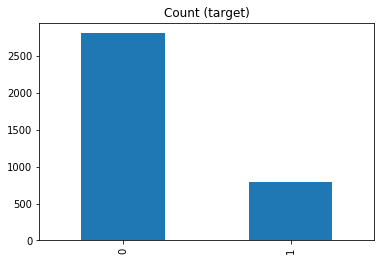

In [17]:
y_test_ud.value_counts().plot(kind='bar', title='Count (target)')


In [19]:
from imblearn.over_sampling import RandomOverSampler
ros=RandomOverSampler(random_state=0)
#X_train_ud,y_train_ud=ros.fit_resample(X_train_ud,y_train_ud)
#X_val_ud,y_val_ud=ros.fit_resample(X_val_ud,y_val_ud)
#X_test_ud,y_test_ud=ros.fit_resample(X_test_ud,y_test_ud)

std_scale = MinMaxScaler().fit(X_train_ud)
X_train_ud = pd.DataFrame(std_scale.transform(X_train_ud))
X_test_ud  = pd.DataFrame(std_scale.transform(X_test_ud))
X_val_ud  = pd.DataFrame(std_scale.transform(X_val_ud))
X_predict_ud  = pd.DataFrame(std_scale.transform(X_predict_ud))
#X_predict  = pd.DataFrame(std_scale.transform(predict_data))

In [22]:

x_train=X_train_ud
x_test=X_test_ud
y_train=y_train_ud
y_test=y_test_ud

In [25]:
d_train = lgb.Dataset(x_train, label=y_train)
params_best = {}
params_best['learning_rate'] = 0.1
params_best['boosting_type'] = 'dart'
params_best['objective'] = 'binary'
params_best['metric'] = 'binary_logloss'
params_best['sub_feature'] = 0.7
params_best['num_leaves'] = 18
params_best['min_data'] = 70
params_best['max_depth'] = 510
params_best['max_bin']=120
params_best['n_estimators']=110
params_best['colsample_bytree' ]=0

params_best = {}
params = {}
params['learning_rate'] = [0.1]
params['boosting_type'] = ['dart']
params['objective'] = ['binary']
params['metric'] = ['binary_logloss']
params['sub_feature'] = [0.7]
params['num_leaves'] = [18]
params['min_data'] = [70]
params['max_depth'] = [510]
params['max_bin']=[120]
params['n_estimators']=[110]

params2={}
params2['learning_rate'] = 0.03
params2['boosting_type'] = 'rf'
params2['objective'] = 'binary'
params2['metric'] = 'binary_logloss'
params2['bagging_fraction'] = 0.5
params2['feature_fraction'] = 0.8
params2['bagging_freq'] = 1
params2['num_leaves'] = 24
params2['min_data'] = 50
params2['max_depth'] = 10
params2['max_bin']=20

clf = lgb.train(params_best, d_train, 100)
clf_a = lgb.train(params2, d_train, 100) #prev_max

#Prediction
test_probs = clf.predict(x_test)
test_probs_a = clf_a.predict(x_test)


def avoid_prob(preds_lgb):
    for i in range(len(preds_lgb)):
        if preds_lgb[i]>=0.5:       # setting threshold to .5
            preds_lgb[i]=1
        else:
            preds_lgb[i]=0
    return preds_lgb

test_preds=avoid_prob(test_probs)

from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score,roc_curve

print(classification_report(y_test,test_preds))
print ('\n')
print(confusion_matrix(y_test,test_preds))
#####
print('prev')
test_probs=test_probs_a
test_preds=avoid_prob(test_probs)

from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score,roc_curve

print(classification_report(y_test,test_preds))
print ('\n')
print(confusion_matrix(y_test,test_preds))



print(classification_report(y_val_ud,avoid_prob( clf.predict(X_val_ud))))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      2810
           1       0.65      0.35      0.45       790

    accuracy                           0.81      3600
   macro avg       0.74      0.65      0.67      3600
weighted avg       0.80      0.81      0.79      3600



[[2660  150]
 [ 517  273]]
prev
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      2810
           1       0.62      0.37      0.46       790

    accuracy                           0.81      3600
   macro avg       0.73      0.65      0.68      3600
weighted avg       0.79      0.81      0.79      3600



[[2631  179]
 [ 497  293]]
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      2791
           1       0.66      0.37      0.48       809

    accuracy                           0.82      3600
   macro avg       0.75      0.66      0.68      3600
weighted av

In [26]:
#use gridsearchcv

mdl = lgb.LGBMClassifier(boosting_type= 'gbdt', 
          objective = 'binary', 
          n_jobs = 5, 
          silent = True,
          max_depth = 10)

# To view the default model parameters:
mdl.get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq'])

In [28]:

gridParams = {
    'learning_rate': [0.005, 0.01],
    'n_estimators': [8,16,24],
    'num_leaves': [6,8,12,16], # large num_leaves helps improve accuracy but might lead to over-fitting
    'boosting_type' : ['gbdt', 'dart'], # for better accuracy -> try dart
    'objective' : ['binary'],
    'max_bin':[255, 510], # large max_bin helps improve accuracy but might slow down training progress
    'random_state' : [500],
    'colsample_bytree' : [0.64, 0.65, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
    }
'''
params = {}
params['learning_rate'] = [0.003,0.001,0.1]
params['boosting_type'] = ['gbdt','dart','rf','goss']
params['objective'] = ['binary']
params['metric'] = ['binary_logloss']
params['sub_feature'] = [0.5,0.2,0.8]
params['num_leaves'] = [6,10,14,18,22]
params['min_data'] = [30,50,70]
params['max_depth'] = [7,10,15,20]
'''

params = {}
params['learning_rate'] = [0.1]
params['boosting_type'] = ['dart']
params['objective'] = ['binary']
params['metric'] = ['binary_logloss']
params['sub_feature'] = [0.7]
params['num_leaves'] = [18]
params['min_data'] = [70]
params['max_depth'] = [510]
params['max_bin']=[120]
params['n_estimators']=[110]


grid = GridSearchCV(mdl, params, verbose=1, cv=4, n_jobs=-1)
# Run the grid
grid.fit(x_train,y_train)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)
probs=grid.predict(x_test)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    3.2s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    3.3s finished


{'boosting_type': 'dart', 'learning_rate': 0.1, 'max_bin': 120, 'max_depth': 510, 'metric': 'binary_logloss', 'min_data': 70, 'n_estimators': 110, 'num_leaves': 18, 'objective': 'binary', 'sub_feature': 0.7}
0.818154761904762


In [29]:
params_best = {}
params_best['learning_rate'] = 0.1
params_best['boosting_type'] = 'dart'
params_best['objective'] = 'binary'
params_best['metric'] = 'binary_logloss'
params_best['sub_feature'] = 0.5
params_best['num_leaves'] = 18
params_best['min_data'] = 70
params_best['max_depth'] = 5
params_best['max_bin']=250
params_best['n_estimators']=110
params_best['colsample_bytree' ]=0
params_best['subsample']=0.000001

In [31]:
probs=grid.predict(X_predict_ud) #this is used as the submission
%store probs

Stored 'probs' (ndarray)
